# Import & Config

In [25]:
!pip install hazm
!pip install kaggle
!pip install sentencepiece

In [26]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import string
import re
import sentencepiece as spm
import random
import math
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from hazm import Normalizer, word_tokenize

In [27]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()

device =  torch.device('cuda' if train_on_gpu else 'cpu')

if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available! Training on GPU ...')

CUDA is available! Training on GPU ...


In [28]:
# from google.colab import drive
# drive.mount('/content/drive')

# Data

## Download dataset from Kaggle

In [29]:
!mkdir ~/.kaggle
!cp ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download miladfa7/persian-wikipedia-dataset -f Persian-WikiText-1.txt

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat './kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/miladfa7/persian-wikipedia-dataset
License(s): CC0-1.0
Persian-WikiText-1.txt.zip: Skipping, found more recently modified local copy (use --force to force download)


In [30]:
!unzip Persian-WikiText-1.txt.zip

Archive:  Persian-WikiText-1.txt.zip
replace Persian-WikiText-1.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Data Preprocessing

In [31]:
def load_file(filepath, percentage=1.0):  # Add percentage parameter
    with open(filepath, 'r', encoding='utf-8') as file:
        all_lines = file.readlines()
        num_lines_to_load = int(len(all_lines) * percentage)
        # Calculate lines based on percentage
        selected_lines = random.sample(all_lines, num_lines_to_load)
        # Randomly select lines
        return selected_lines


def save_file(filepath, data):
    with open(filepath, 'w', encoding='utf-8') as file:
        file.write('\n'.join(data))

normalizer = Normalizer()

data = load_file('Persian-WikiText-1.txt', percentage=.3)

# Normalize and Clean the text
def clean_text(text):
    normalized_text = normalizer.normalize(text)

    # Remove non-Persian characters (keep Persian letters, spaces, and basic punctuation) and extra spaces
    text = re.sub(r"[^آ-یء\s.,؟؛!]", "", text)
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)
    text = re.sub(r"\s+", " ", text).strip()
    words = word_tokenize(text)
    return ' '.join(word for word in words)

In [32]:
# Clean the data and save it to a file

cleaned_text = [clean_text(line) for line in data]
save_file('cleaned_persian_text.txt', cleaned_text)

In [33]:
# Train the SentencePiece model
# Sentencepiece training.

spm.SentencePieceTrainer.train(
    input='cleaned_persian_text.txt',
    model_prefix='bpe',
    vocab_size=5000,
    character_coverage=1.0,
    input_sentence_size=5000,
    shuffle_input_sentence=True,
    model_type='bpe'
)

sp = spm.SentencePieceProcessor(model_file='bpe.model')

def tokenize_text(lines, tokenizer):
    result = []
    for line in lines:
        tokenized_line = tokenizer.encode(clean_text(line), out_type=str)
        if tokenized_line:  # Check if the tokenized line is not empty
            result.append(' '.join(tokenized_line))
    print("Sample tokenized text:", result[:2])
    return result

tokenized_data = tokenize_text(cleaned_text, sp)
print("Preprocessing and tokenization completed!")

Sample tokenized text: ['▁آبشار ▁ک یم ون ▁این ▁آبشار ▁در ▁بخش ▁بند پی ▁شرقی ▁شهرستان ▁با بل ▁قرار ▁دارد ▁معرفی ▁بیشتر', '▁براساس ▁پایگاه ▁های ▁معتبر ▁برای ▁رتبه ▁بندی ▁دانشگاه ▁ها ▁در ▁جهان ▁دانشگاه ▁صنعتی ▁خواجه ▁نص یر الدین ▁ط وسی ▁پیشرفت ▁و ▁رشد ▁محس وسی ▁داشته است ▁بر ط بق ▁آمار ِ ▁پایگاه ▁رتبه ▁بندی ▁این ▁دانشگاه ▁در ▁شمار ▁درصد ▁تولید کن ندگان ▁علم ▁در ▁دنیا ▁معرفی ▁شده است ▁همچنین ▁در ▁رتبه ▁بندی ▁نشریه ▁تای مز ▁در ▁سال ▁این ▁دانشگاه ▁در ▁جایگاه ▁تا ▁جهان ▁و ▁در ▁رتبه ▁آسیا ▁و ▁در ▁بین ▁دانشگاه ▁برتر ▁ایران ▁و ▁بالاتر ▁از ▁دانشگاه ▁هایی ▁همچون ▁شریف ▁و ▁تهران ▁قرار ▁گرفت']
Preprocessing and tokenization completed!


# Dataloader

In [34]:
# Reduce the dataset size
# Reducing dataset size

# reduce_size = 100000 // 2
reduce_size = 5000
sampled_lines = random.sample(tokenized_data, min(reduce_size, len(tokenized_data)))

with open("small_cleaned_persian_text.txt", "w", encoding="utf-8") as f:
    f.writelines(sampled_lines)

print(f"Smaller dataset created with {len(sampled_lines)} lines.")

Smaller dataset created with 5000 lines.


In [35]:
# Define the NGramDataset class and create_dataloaders function
# Dataloader class and functions

class NGramDataset(Dataset):
    def __init__(self, tokenized_data, n=3):
        self.data = []
        self.targets = []
        self.n = n

        # Build n-grams from tokenized data
        for sequence in tokenized_data:
            if len(sequence) < n:
                continue
            for i in range(len(sequence) - n + 1):
                ngram = sequence[i:i + n]
                self.data.append(ngram[:-1])  # Input: first n-1 tokens
                self.targets.append(ngram[-1])  # Output: nth token (target)

        # Build vocabulary
        all_tokens = [token for seq in tokenized_data for token in seq]
        self.vocab = list(set(all_tokens))
        self.token_to_index = {token: idx for idx, token in enumerate(self.vocab)}
        self.index_to_token = {idx: token for token, idx in self.token_to_index.items()}

        # Convert n-grams to numerical format
        self.data = [[self.token_to_index[token] for token in ngram] for ngram in self.data]
        self.targets = [self.token_to_index[target] for target in self.targets]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.data[idx], dtype=torch.long),
            torch.tensor(self.targets[idx], dtype=torch.long),
        )


def create_dataloaders(tokenized_data, n=3, batch_size=64, train_ratio=0.7, val_ratio=0.15):
    # Create dataset
    dataset = NGramDataset(tokenized_data, n=n)

    # Split into train, validation, and test sets
    total_size = len(dataset)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    print(f"Dataset sizes: train={len(train_dataset)}, val={len(val_dataset)}, test={len(test_dataset)}")

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Dataloader sizes: train={len(train_loader)}, val={len(val_loader)}, test={len(test_loader)}")
    return train_loader, val_loader, test_loader



In [36]:
# Create the dataloaders
n_gram = 5
train_loader, val_loader, test_loader = create_dataloaders(
    tokenized_data=sampled_lines,
    n=n_gram,
    batch_size=128
)

vocab_size = len(train_loader.dataset.dataset.vocab)  # Vocabulary size
print(f"Vocab size: {vocab_size}")


Dataset sizes: train=1104586, val=236697, test=236698
Dataloader sizes: train=8630, val=1850, test=1850
Vocab size: 65


# Model

In [37]:
class Persian_LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout=0.2):
        super(Persian_LSTM, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, vocab_size)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
            torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))

    def forward(self, x, hidden=None):
        # Embedding layer
        embedded = self.dropout(self.embedding(x))  # Shape: (batch_size, seq_len, embedding_dim)

        # LSTM layer
        out, hidden = self.lstm(embedded, hidden)  # out: (batch_size, seq_len, hidden_dim)

        # Fully connected layer (project LSTM outputs to vocab size)
        logits = self.fc(out)  # Shape: (batch_size, seq_len, vocab_size)

        return logits, hidden

In [38]:
class Persian_Transformer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, hidden_dim, num_layers, dropout=0.2):
        super(Persian_Transformer, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Positional encoding (sinusoidal)
        self.positional_encoding = nn.Parameter(
            self._create_positional_encoding(512, embedding_dim), requires_grad=False
        )

        # Create a Transformer decoder layer
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True
        )

        # Create the Transformer decoder with the specified number of layers
        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=num_layers
        )

        # Output projection to vocab size
        self.fc = nn.Linear(embedding_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def _create_positional_encoding(self, max_len, d_model):
        """Generate sinusoidal positional encodings."""
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)  # Shape: [1, max_len, d_model]

    def forward(self, x):
        # Input shape: [batch_size, seq_len]
        batch_size, seq_len = x.size()

        # Add positional encodings to the embeddings
        positions = self.positional_encoding[:, :seq_len, :]  # Shape: [1, seq_len, embedding_dim]
        embedded = self.embedding(x) + positions  # Shape: [batch_size, seq_len, embedding_dim]
        embedded = self.dropout(embedded)

        # Causal mask to prevent attending to future tokens
        causal_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool().to(x.device)
        key_padding_mask = torch.zeros(batch_size, seq_len).bool().to(x.device)

        # Pass through transformer decoder (decoder-only mode)
        transformer_out = self.transformer_decoder(
            tgt=embedded,
            memory=embedded,
            tgt_mask=causal_mask,
            tgt_key_padding_mask=key_padding_mask
        )

        # Project to vocab size for logits
        logits = self.fc(transformer_out)  # Shape: [batch_size, seq_len, vocab_size]
        return logits


In [39]:
def save_checkpoint(model, optimizer, epoch, train_loss, filepath="model_checkpoint.pth"):
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "train_loss": train_loss,
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved at '{filepath}'")

def load_checkpoint(filepath, model, optimizer):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]
    train_loss = checkpoint["train_loss"]
    print(f"Checkpoint loaded from '{filepath}'")
    return epoch


In [40]:
def train_model(model, train_loader, val_loader, num_epochs, checkpoint_path="model_checkpoint.pth"):
    # Tracking metrics
    train_losses = []
    val_losses = []
    best_val_loss = float("inf")
    start_epoch = 0

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Load checkpoint if exists
    # try:
    #     start_epoch = load_checkpoint(checkpoint_path, model, optimizer)
    #     print(f"Resuming training from epoch {start_epoch + 1}")

    #     # Add print statements after loading the checkpoint
    #     print("Checkpoint content:")
    #     checkpoint = torch.load(checkpoint_path)
    #     print(f"  Checkpoint keys: {checkpoint.keys()}")
    #     print(f"  Model state dict keys: {checkpoint['model_state_dict'].keys()}")
    # except FileNotFoundError:
    #     print("No checkpoint found, starting training from scratch.")

    for epoch in range(start_epoch, num_epochs):
        # Training phase
        model.to(device)
        model.train()
        total_train_loss = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            if isinstance(model, Persian_LSTM):  # Handle LSTM model
                outputs, _ = model(inputs)  # Unpack outputs and hidden state
            else:  # Handle Transformer model
                outputs = model(inputs)

            outputs = outputs[:, -1, :].squeeze(1)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                if isinstance(model, Persian_LSTM):  # Handle LSTM model
                    outputs, _ = model(inputs)  # Unpack outputs and hidden state
                else:  # Handle Transformer model
                    outputs = model(inputs)

                outputs = outputs[:, -1, :].squeeze(1)
                loss = criterion(outputs, targets)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Save checkpoint if validation loss improves
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_checkpoint(model, optimizer, epoch, avg_train_loss, filepath=checkpoint_path)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses


In [41]:
def evaluate(model, test_loader, top_n_classes=10):
    model.eval()

    test_loss = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        all_targets = []
        all_predictions = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            if isinstance(model, Persian_LSTM):  # Handle LSTM model
                outputs, _ = model(inputs)  # Unpack outputs and hidden state
            else:  # Handle Transformer model
                outputs = model(inputs)
            outputs = outputs[:, -1, :].squeeze(1)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            predictions = torch.argmax(outputs, dim=1)
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

        # Print statement to check sizes
        print(f"All_targets: {len(all_targets)}, all_predictions: {len(all_predictions)}")

        # Get the top N most frequent classes
        unique, counts = np.unique(all_targets, return_counts=True)
        top_classes = unique[np.argsort(counts)[-top_n_classes:]]

        # Filter confusion matrix for top N classes
        filtered_targets = [t for t in all_targets if t in top_classes]
        filtered_predictions = [p for p, t in zip(all_predictions, all_targets) if t in top_classes]

        # Compute confusion matrix
        cm = confusion_matrix(filtered_targets, filtered_predictions, labels=top_classes, normalize="true")

        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=top_classes)
        fig, ax = plt.subplots(figsize=(8, 8))  # Adjust size for readability
        disp.plot(cmap="Blues", ax=ax, xticks_rotation="vertical", values_format=".2f")
        plt.title(f" Confusion Matrix (Top {top_n_classes} Classes) {'LSTM' if isinstance(model, Persian_LSTM) else 'Transformer'}")
        plt.show()

    # Average test loss
    test_loss /= len(test_loader)
    perplexity = torch.exp(torch.tensor(test_loss))
    print(f"Test Loss: {test_loss:.4f} | Perplexity: {perplexity:.4f}")
    return test_loss, perplexity


def plot_loss(train_losses, val_losses, num_epochs):
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()


In [42]:
# Initialize models and hyperparameters
# Define model hyperparameters

vocab_size = len(train_loader.dataset.dataset.vocab)  # Vocabulary size
embedding_dim = 128  # Dimension of word embeddings
hidden_dim = 128  # Number of LSTM units
num_layers = 2  # Number of LSTM layers
dropout = 0.2  # Dropout for regularization
num_epochs = 20

# Initialize the model
lstm_model = Persian_LSTM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout=dropout
)

transformer_model = Persian_Transformer(
    num_heads=8,
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout=dropout
).to(device)

# Print the model architecture
print(lstm_model)
print(transformer_model)

Persian_LSTM(
  (embedding): Embedding(65, 128)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=65, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Persian_Transformer(
  (embedding): Embedding(65, 128)
  (transformer_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=128, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps

In [43]:
# Train the LSTM Model

model = lstm_model

train_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    num_epochs,
    checkpoint_path="lstm_checkpoint.pth"
    )

Checkpoint saved at 'lstm_checkpoint.pth'
Epoch 1/20, Train Loss: 1.7574, Val Loss: 1.5570
Checkpoint saved at 'lstm_checkpoint.pth'
Epoch 2/20, Train Loss: 1.5588, Val Loss: 1.4895
Checkpoint saved at 'lstm_checkpoint.pth'
Epoch 3/20, Train Loss: 1.5120, Val Loss: 1.4597
Checkpoint saved at 'lstm_checkpoint.pth'
Epoch 4/20, Train Loss: 1.4888, Val Loss: 1.4450
Checkpoint saved at 'lstm_checkpoint.pth'
Epoch 5/20, Train Loss: 1.4745, Val Loss: 1.4339
Checkpoint saved at 'lstm_checkpoint.pth'
Epoch 6/20, Train Loss: 1.4639, Val Loss: 1.4297
Checkpoint saved at 'lstm_checkpoint.pth'
Epoch 7/20, Train Loss: 1.4562, Val Loss: 1.4209
Checkpoint saved at 'lstm_checkpoint.pth'
Epoch 8/20, Train Loss: 1.4498, Val Loss: 1.4177
Checkpoint saved at 'lstm_checkpoint.pth'
Epoch 9/20, Train Loss: 1.4450, Val Loss: 1.4136
Checkpoint saved at 'lstm_checkpoint.pth'
Epoch 10/20, Train Loss: 1.4403, Val Loss: 1.4098
Checkpoint saved at 'lstm_checkpoint.pth'
Epoch 11/20, Train Loss: 1.4372, Val Loss: 1.40

All_targets: 236698, all_predictions: 236698


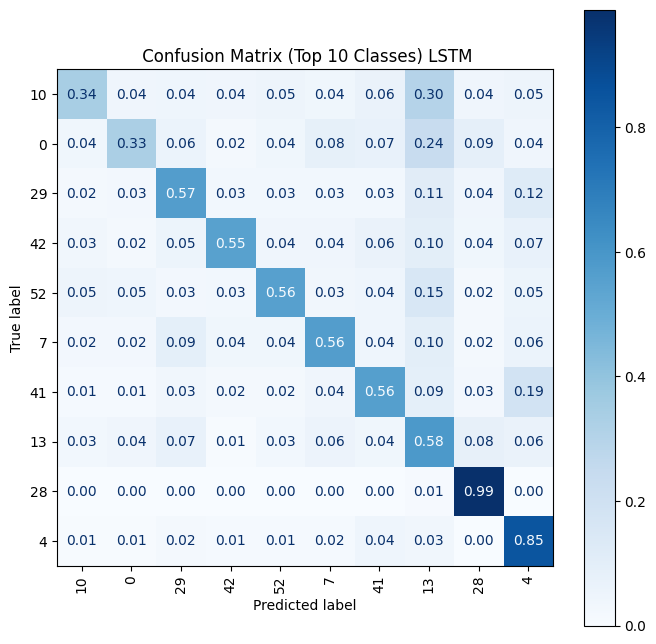

Test Loss: 1.3936 | Perplexity: 4.0292


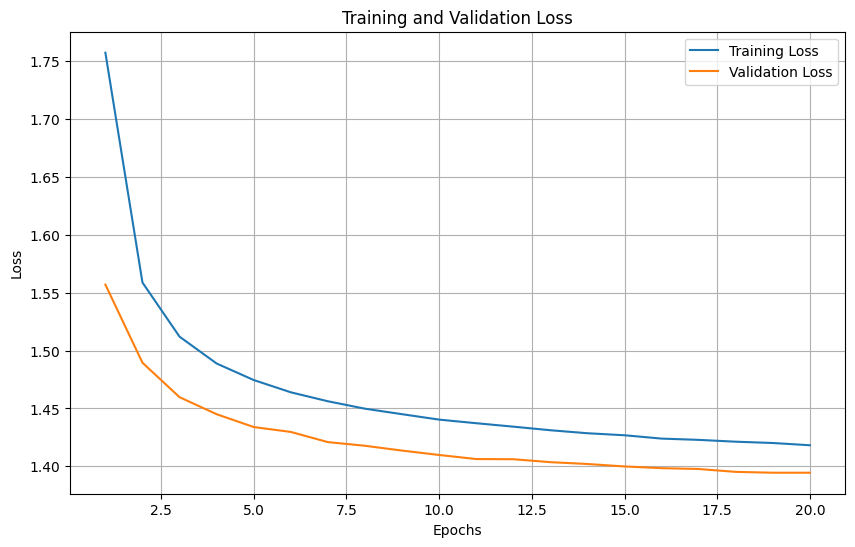

In [44]:
test_loss, perplexity = evaluate(model, test_loader)

plot_loss(train_losses, val_losses, num_epochs)

In [45]:
# Train the Transformer Model

model = transformer_model

train_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    num_epochs,
    checkpoint_path = "Transformer_checkpoint.pth"
    )

Checkpoint saved at 'Transformer_checkpoint.pth'
Epoch 1/20, Train Loss: 1.9083, Val Loss: 1.7662
Checkpoint saved at 'Transformer_checkpoint.pth'
Epoch 2/20, Train Loss: 1.8206, Val Loss: 1.7126
Checkpoint saved at 'Transformer_checkpoint.pth'
Epoch 3/20, Train Loss: 1.8051, Val Loss: 1.7055
Checkpoint saved at 'Transformer_checkpoint.pth'
Epoch 4/20, Train Loss: 1.8009, Val Loss: 1.6964
Epoch 5/20, Train Loss: 1.8057, Val Loss: 1.7013
Epoch 6/20, Train Loss: 1.8109, Val Loss: 1.7073
Epoch 7/20, Train Loss: 1.8151, Val Loss: 1.7285
Epoch 8/20, Train Loss: 1.8231, Val Loss: 1.7192
Epoch 9/20, Train Loss: 1.8309, Val Loss: 1.7257
Epoch 10/20, Train Loss: 1.8403, Val Loss: 1.7400
Epoch 11/20, Train Loss: 1.8481, Val Loss: 1.7343
Epoch 12/20, Train Loss: 1.8714, Val Loss: 1.7575
Epoch 13/20, Train Loss: 1.8847, Val Loss: 1.7625
Epoch 14/20, Train Loss: 1.8887, Val Loss: 1.7776
Epoch 15/20, Train Loss: 1.8932, Val Loss: 1.8084
Epoch 16/20, Train Loss: 1.9206, Val Loss: 1.8081
Epoch 17/20, 

All_targets: 236698, all_predictions: 236698


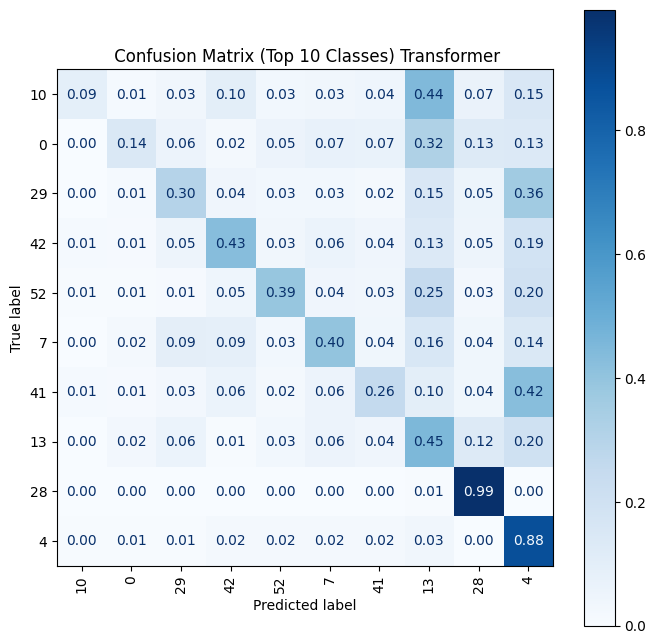

Test Loss: 1.7839 | Perplexity: 5.9531


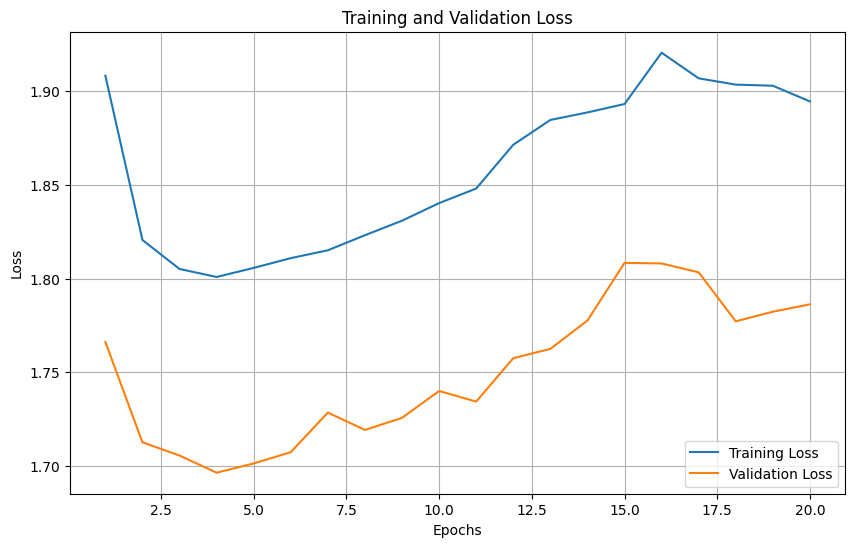

In [46]:
test_loss, perplexity = evaluate(model, test_loader)

plot_loss(train_losses, val_losses, num_epochs)

In [47]:
def generate_text(model, start_tokens, max_length, tokenizer, temperature=1.0):
    """
    Generates text given a starting sequence of tokens using a model.

    Args:
        model: Trained model (LSTM or Transformer).
        start_tokens (list): List of starting tokens (integers).
        max_length (int): Maximum length of generated text.
        tokenizer (sentencepiece.SentencePieceProcessor): Tokenizer object to convert tokens to text.
        device: Device to use (CPU or GPU).
        temperature (float): Temperature for sampling from the probability distribution.

    Returns:
        str: Generated text.
    """
    model.eval()  # Set model to evaluation mode
    # model.to(device)  # Remove this line to avoid moving the model again

    with torch.no_grad():
        # Ensure input_seq is on the correct device and within vocabulary bounds
        input_seq = torch.tensor([t for t in start_tokens if t < model.embedding.num_embeddings], dtype=torch.long).unsqueeze(0).to(device)  # Shape: [1, seq_len]

        # Check if input_seq is empty after filtering
        if input_seq.shape[1] == 0:
            print("WARNING: All starting tokens are out of vocabulary. Using UNK token to start generation.")
            input_seq = torch.tensor([[tokenizer.unk_id()]], dtype=torch.long).to(device)  # Start with UNK token
            generated_tokens = [tokenizer.unk_id()]  # Initialize with UNK token
        else:
            generated_tokens = start_tokens.copy()

        for _ in range(max_length - len(start_tokens)):
            if isinstance(model, Persian_LSTM):
                output, _ = model(input_seq)  # Shape: [1, seq_len, vocab_size]
            elif isinstance(model, Persian_Transformer):
                output = model(input_seq)
            else:
                raise ValueError("Model type not supported.")

            # Get last token's logits
            output = output[:, -1, :]  # Shape: [1, vocab_size]

            # Apply temperature scaling
            output = output / temperature

            # Convert logits to probabilities
            probs = torch.softmax(output, dim=-1)  # Shape: [1, vocab_size]

            # Check if probs contain NaN or inf values
            if torch.isnan(probs).any() or torch.isinf(probs).any():
                print("Probs contains NaN or inf, skipping this step")
                continue  # Skip this step and try the next one

            # Sample token from the distribution
            next_token = torch.multinomial(probs, num_samples=1)  # Shape: [1, 1]

            # Append to generated tokens and update input seq
            next_token = next_token.item()
            generated_tokens.append(next_token)

            # Check if next_token is within the valid vocabulary range
            if next_token >= model.embedding.num_embeddings:
                print(f"WARNING: Generated token ID {next_token} is out of vocabulary range. Replacing with <UNK> token.")
                # Replace out-of-vocabulary token with the unknown token ID
                next_token = tokenizer.unk_id() # Or any other fallback token ID

            # Ensure the new token is on the correct device and within vocabulary bounds
            input_seq = torch.cat((input_seq, torch.tensor([[next_token]], dtype=torch.long).to(device)), dim=1)

        # Decode the generated tokens back to text
        decoded_text = tokenizer.decode(generated_tokens)
        return decoded_text

In [48]:
# Generate text with both models

seed_text = "ایران کشوری "

# Tokenize the seed text before passing to generate_text
start_tokens_lstm = sp.encode(seed_text, out_type=int)  # Encode to token IDs
generated_text_lstm = generate_text(lstm_model, start_tokens_lstm, max_length=50, tokenizer=sp, temperature=0.7)
print("LSTM generated text:", '\n', generated_text_lstm)

# Tokenize the seed text before passing to generate_text
start_tokens_transformer = sp.encode(seed_text, out_type=int)  # Encode to token IDs
generated_text_transformer = generate_text(transformer_model, start_tokens_transformer, max_length=50, tokenizer=sp, temperature=0.7)
print("Transformer generated text:", '\n', generated_text_transformer)

LSTM generated text: 
  ⁇ ان بال زان بال ⁇  بالده ف ز بال زان بالیر پ بالیرست است ز بال زان بالستده بالیر پ بالادودان بر ب است ب
Transformer generated text: 
  ⁇  ف ز بال گستایفتیریر ف است براد پشتیرادیرای ⁇ ایستیرست آ پستیراد گایلییریر فستای ⁇  پ گیر ز میستای ففت
